# IDS 576: Assignment 3

Patricia Maya

# **1.** RNN for Language Modeling (4pt)

 -  Import the torchtext IMDB dataset and do the following:
   -  Build a  Markov (n-gram) language model.
   -  Change the output and the model appropriately in _[Simple Sentiment Analysis.ipynb](https://github.com/bentrevett/pytorch-sentiment-analysis)_ (also available [here](https://github.com/thejat/dl-notebooks/blob/master/examples/Seq2Seq_RNN_Simple_Sentiment_Analysis.ipynb) where the imports have been slightly modified) to build an LSTM based language model. Plot the training performance as a function of epochs/iterations.
 -  For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality.
 -  For each model, starting with the phrase "My favorite movie ", sample the next few words and create an approx. 20 word generated review. Repeat this 5 times (you should ideally get different outputs each time) and report the outputs.
 - Note: make any assumptions as necessary.

Language Modeling:
- Give RNN a large text dataset
- Model the probability of the next character given a sequence of previous characters

### Building a Markov (n-gram) language model.

In [3]:
import torch
import torchtext

from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Preparing Data
One of the main concepts of TorchText is the `Field`. These define how your data should be processed.

We use the `TEXT` field to define how the review should be processed.

LABEL is defined by a LabelField, a special subset of the Field class specifically used for handling labels.

In [4]:
N=4
def make_ngrams(sequence):
    """ Returns a list of n-long ngrams from a sequence """
    """ To change number of n just replace N above to desired n-gram  """
    n_grams = list(zip(*[sequence[i:] for i in range(N)]))
    corpus = [] 
    for i in n_grams:
        corpus.append(' '.join(i)) 
    return corpus 

In [5]:
TEXT = data.Field(tokenize='spacy', preprocessing=make_ngrams)
LABEL = data.LabelField(dtype = torch.float)

In [6]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [7]:
#We can also check some examples.
print(vars(train_data.examples[1]))

{'text': ['I love it when', 'love it when they', 'it when they actually', 'when they actually do', 'they actually do a', 'actually do a sports', 'do a sports story', 'a sports story well', 'sports story well .', 'story well . So', 'well . So many', '. So many in', 'So many in the', 'many in the past', 'in the past have', 'the past have been', 'past have been so', 'have been so hokey', 'been so hokey it', 'so hokey it was', 'hokey it was embarrassing', 'it was embarrassing to', 'was embarrassing to watch', 'embarrassing to watch .', 'to watch . Not', 'watch . Not this', '. Not this one', 'Not this one .', 'this one . It', "one . It 's", ". It 's just", "It 's just a", "'s just a genuinely", 'just a genuinely nice', 'a genuinely nice movie', 'genuinely nice movie ,', 'nice movie , an', 'movie , an old', ', an old -', 'an old - fashioned', 'old - fashioned type', '- fashioned type of', 'fashioned type of story', 'type of story -', 'of story - and', 'story - and based', '- and based on', '

In [8]:
#splitting train data into 70 train/30 validation
import random
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
print(f'Number of training examples: {len(train_data)}') 
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [9]:
#keeping ONLY the top 25,000 words. (most common max_size tokens.)
MAX_VOCAB_SIZE = 25000

#BUILD A VOCABULARY 
#This is a effectively a look up table where every unique word in your data set 
#has a corresponding _index_ (an integer).

#Each index is used to construct a one-hot vector for each word. 
TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
text_dictionary = dict(TEXT.vocab.freqs)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
#Why is the vocab size 25002 and not 25000? One of the addition tokens is the 
#`<unk>` token and the other is a `<pad>` token.

Unique tokens in TEXT vocabulary: 25002


In [10]:
#see most common n-grams
print(TEXT.vocab.freqs.most_common(10))

[('. < br /><br', 2826), ('! ! ! !', 1377), ('* * * *', 814), ('is one of the', 748), ('< br /><br />The', 649), ('the rest of the', 583), ('one of the most', 568), (". I do n't", 546), (". It 's a", 545), ('the end of the', 514)]


In [27]:
#create a df with every n_gram and its frequency as well as n_gram - 1 and its respective target 
import pandas as pd
x= N-1
mkv_model = pd.DataFrame.from_dict(text_dictionary, orient="index")
mkv_model = mkv_model.reset_index()
mkv_model.columns = ["n_gram","frequency"]
mkv_model["n_minus1_gram"] = mkv_model.n_gram.apply(lambda i: " ".join(i.split(" ")[:x]))
mkv_model["goal"] = mkv_model.n_gram.apply(lambda i: i.split(" ")[x])
gram_count = pd.DataFrame(mkv_model.groupby("n_minus1_gram",as_index=False)["frequency"].sum())
mkv_model.head(5)

,n_gram,frequency,n_minus1_gram,goal
0,JUST CAUSE showcases Sean,1,JUST CAUSE showcases,Sean
1,CAUSE showcases Sean Connery,1,CAUSE showcases Sean,Connery
2,showcases Sean Connery as,1,showcases Sean Connery,as
3,Sean Connery as a,1,Sean Connery as,a
4,Connery as a Harvard,1,Connery as a,Harvard


### Build an LSTM based language model

Change the output and the model appropriately in Simple Sentiment Analysis.ipynb (also available here where the imports have been slightly modified) to build an LSTM based language model. Plot the training performance as a function of epochs/iterations.

In [1]:
import torch
import torchtext
from torchtext.legacy import data
from torchtext.legacy import datasets
import random
import torch.nn as nn
import torch.nn.functional as F
SEED=1234
TEXT = data.Field()
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED), split_ratio=0.20)

print(f'Training examples: {len(train_data)}')
print(f'Validation examples: {len(valid_data)}')
print(f'Testing examples: {len(test_data)}')

TEXT.build_vocab(train_data, max_size=2000)
LABEL.build_vocab(train_data)

#creating the iterators. 
batch_size = 15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = batch_size,
    device = device)

aclImdb_v1.tar.gz:   0%|          | 147k/84.1M [00:00<01:11, 1.18MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 60.5MB/s]


Training examples: 5000
Validation examples: 20000
Testing examples: 25000


In [2]:
#building the model
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, batch_size, output_dim):    
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, output_dim)

    def forward(self, text):
        #text = [sent len, batch size]
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim] - concatenation of the hidden state from every time step
        #hidden = [1, batch size, hid dim] -  the final hidden state 
        
        dim = output.size()
        output = output.view(-1, output.shape[2])
        new_output = F.log_softmax(output, dim=1)
        #assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        if batch_size==dim[1]:
            new_output = new_output.view(-1, OUTPUT_DIM, batch_size)
        else:
            new_output = new_output.view(dim[1], OUTPUT_DIM,-1)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]       
        return new_output
    

In [3]:
#create an instance of our RNN class

INPUT_DIM = len(TEXT.vocab) # the dimension of the one-hot vectors, which is equal to the vocabulary size.
EMBEDDING_DIM = 100 #size of the dense word vectors, usually around 50-250 dimensions
OUTPUT_DIM = len(TEXT.vocab) 

model = LSTM(INPUT_DIM, EMBEDDING_DIM, batch_size,OUTPUT_DIM)

In [4]:
#function that will tell us how many trainable parameters our model has so we can compare 
#the number of parameters across different models.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,049,032 trainable parameters


#### Train the Model

In [5]:
#create an optimizer using stochastic gradient descent (SGD)
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)
#first argument: parameters will be updated by the optimizer, the second: learning rate

#define our loss function
criterion = nn.NLLLoss()

#Using .to, we can place the model and the criterion on the GPU (if we have one).
model = model.to(device)
criterion = criterion.to(device)

In [7]:
def train(model, iterator, optimizer, criterion,BATCH_SIZE):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_label_count = 0 
    loss=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()   
        predictions = model(batch.text)

        dim = predictions.size()
        if dim[2] !=BATCH_SIZE:
            BATCH_SIZE = dim[2]
            
        pad = torch.tensor([1]*BATCH_SIZE,device=device).view(BATCH_SIZE,-1)
        _,preds = torch.max(predictions,1)
        labels = batch.text.view(-1,BATCH_SIZE)
        labels = labels[1:]
        pad = torch.tensor([1]*BATCH_SIZE,device=device).view(-1,BATCH_SIZE)
        labels = torch.cat((labels,pad),0)
        loss = criterion(predictions,labels)
        acc = torch.sum(preds == labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_label_count+= labels.numel()
        
    return epoch_loss / len(iterator) , (epoch_acc /epoch_label_count)

In [9]:
#train the model through multiple epochs
N_EPOCHS = 5
training_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, batch_size)
    training_losses.append(train_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01
	 Train Loss: 7.513 | Train Acc: 3.35%
Epoch: 02
	 Train Loss: 7.411 | Train Acc: 4.31%
Epoch: 03
	 Train Loss: 7.340 | Train Acc: 4.01%
Epoch: 04
	 Train Loss: 7.273 | Train Acc: 4.35%
Epoch: 05
	 Train Loss: 7.247 | Train Acc: 4.57%


Training performance as a function of epochs/iterations.

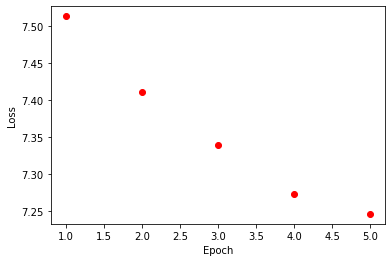

In [10]:
import matplotlib.pyplot as plt
plt.scatter(x=range(1, N_EPOCHS +1) , y=training_losses, c='red')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

- For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality.


In order to build the Markov (n-gram) language model, I decided to use n=4 (quadrigram) as I saw an example that trained with Shakespeare as corpus with n=4 and the predictions by the model were very good. 


To build an LSTM based language model, I added the input layer, then the embediding layer, and lastly the lstm layer. 

It is important to note that I only trained the LSTM model with 5000 training examples and only take the top 2000 most common words and a small epoch number because I did not have enough RAM. 




 -  For each model, starting with the phrase "My favorite movie ", sample the next few words and create an approx. 20 word generated review. Repeat this 5 times (you should ideally get different outputs each time) and report the outputs.

Generating reviews for model 2

In [63]:
import numpy as np
for j in range(5):
    phrase = torch.tensor([[TEXT.vocab.stoi["My"]],[TEXT.vocab.stoi["favorite"]],[TEXT.vocab.stoi["movie"]]],device="cuda:0")
    for i in range(15):
        x = model(phrase) #size [1, 2002, 3]
        x = x.squeeze(0) #size [2002, 3]
        x = x[: , x.size()[1]-1].detach().cpu().numpy()
        x = np.sort(x)[::-1]
        x = x[:500] 
        new_phrase = torch.tensor(np.where(op==np.random.choice(op,1)),device="cuda:0")
        phrase = torch.cat((phrase , new_phrase))  
    newly_generated = ""
    for y in phrase:
        newly_generated = newly_generated + " " + TEXT.vocab.itos[y]
    gen_length = len(newly_generated.split(sep=" "))
    print(f'New generated review {str(j+1)}:')
    print(f'\t {newly_generated}.')

New generated review 1:
	  My favorite movie your seemed time anyone In American actually short performances early used me. New starts later.
New generated review 2:
	  My favorite movie TV New times care i small reason of after it's she The early what movie..
New generated review 3:
	  My favorite movie camera remember low on comedy looks fact my care favorite His <unk> been try lost.
New generated review 4:
	  My favorite movie she's the them. film, small just action acting shows favorite our had early scene go.
New generated review 5:
	  My favorite movie couldn't done nothing  head only guy fun instead recommend job isn't understand final movie..


# **2.** Sequence to Sequence Model for Translation (4pt)

 -  Train the sequence to sequence model ([Model 1](https://github.com/thejat/dl-notebooks/blob/master/examples/Seq2Seq_Translation_Example.ipynb)) for a language pair (excluding French-English), where the output is English and the input is a language of [your choice](https://www.manythings.org/anki/).
 -  Now train another model (Model 2) for the reverse (i.e., from English to the language you chose). In this model, use the GloVe 100 dimensional embeddings. See notebook 4, cell 2 for an [example](https://github.com/bentrevett/pytorch-sentiment-analysis) while training.
 -  Input 5 well formed sentences from the English vocab to Model 2, and input the resultant translated sentences to Model 1. Display all model outputs in each case.
 - Note: make any assumptions as necessary.

In this project we will be teaching a neural network to translate from **Spanish to English**.

Code of part 2 adapted from various sources: 

https://gist.github.com/martinpella/a22bb1d4687f1ab9eb6679e0c10729ad#file-glove_load-py

https://github.com/thejat/dl-notebooks/blob/master/examples/Seq2Seq_Translation_Example.ipynb

https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

https://gist.github.com/martinpella/79437e77fe77dfacb936bfbbea1a216f#file-weights_matrix-py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<SOS>": 0,"<EOS>": 1}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
#The files are all in Unicode, to simplify we will turn Unicode characters 
#to ASCII, make everything lowercase, and trim most punctuation.
# https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/drive/MyDrive/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a lot of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes replaced earlier).

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

def filterPair(p, reverse = False):
    if reverse == False:
        return len(p[1].split(' ')) < MAX_LENGTH and \
                len(p[0].split(' ')) < MAX_LENGTH and \
                p[0].startswith(eng_prefixes)           
    else:
      return len(p[0].split(' ')) < MAX_LENGTH and \
                len(p[1].split(' ')) < MAX_LENGTH and \
                p[1].startswith(eng_prefixes)

def filterPairs(pairs, reverse=False):
    return [pair for pair in pairs if filterPair(pair, reverse=reverse)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, reverse=reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'spa', True)
print(random.choice(pairs))

['el accidente es culpa suya .', 'he is to blame for the accident .']


## Sequence to Sequence network
A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the black cat". Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. "chat noir" and "black cat". Because of the "ne/pas" construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the "meaning" of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### The Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention Decoder
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

### Preparing Training Data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### Training fucntions
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

In [11]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length
####

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting
- Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [12]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    
#plotting results 
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


#### Evaluate functions

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#We can evaluate random sentences from the training set and print out the input,
#target, and output to make some subjective quality judgements

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
    

## Training & Evaluating Model 1

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

5m 36s (- 78m 34s) (5000 6%) 3.0159
11m 15s (- 73m 12s) (10000 13%) 2.3936
16m 52s (- 67m 31s) (15000 20%) 1.9997
22m 30s (- 61m 52s) (20000 26%) 1.7157
28m 9s (- 56m 18s) (25000 33%) 1.4706
33m 45s (- 50m 37s) (30000 40%) 1.2758
39m 27s (- 45m 5s) (35000 46%) 1.1324
45m 5s (- 39m 27s) (40000 53%) 0.9368
50m 46s (- 33m 50s) (45000 60%) 0.8584
56m 24s (- 28m 12s) (50000 66%) 0.7409
62m 0s (- 22m 32s) (55000 73%) 0.6590
67m 37s (- 16m 54s) (60000 80%) 0.5891
73m 15s (- 11m 16s) (65000 86%) 0.5108
78m 55s (- 5m 38s) (70000 93%) 0.4644
84m 33s (- 0m 0s) (75000 100%) 0.4162


In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> sos importante .
= you are important .
< you are important . <EOS>

> mola tocar m sica contigo .
= you re fun to play music with .
< you re fun to play music with . <EOS>

> ella ama las flores .
= she is very fond of flowers .
< she is very fond of flowers . <EOS>

> lo estoy esperando .
= i m waiting for him .
< i m waiting for you . <EOS>

> estoy cansado de la tele .
= i m tired of tv .
< i am tired of tv . <EOS>

> no tienes edad para tomar .
= you re not old enough to drink .
< you re not old enough to . . <EOS>

> est s empapado .
= you re soaking wet .
< you re soaking wet . <EOS>

> soy un artista .
= i am an artist .
< i am an artist . <EOS>

> ellos est n bien .
= they re fine .
< they re fine . <EOS>

> estamos todos invitados .
= we re all invited .
< we re all invited . <EOS>



- Now train another model (Model 2) for the reverse (i.e., from English to the language you chose). In this model, use the GloVe 100 dimensional embeddings. See notebook 4, cell 2 for an example while training.

Pre-trained word vectors Glove.6B -- Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB):

#### Load GloVe 100

Given that the vocabulary has 400k tokens, will use bcolz to store the array of vectors. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
#!pip install bcolz
import bcolz
import numpy as np
import pickle 

words = []
idx = 0
word2idx = {}

path = '/content/drive/MyDrive'
vectors = bcolz.carray(np.zeros(1), rootdir=f'{path}/6B.100.dat', mode='w')

with open(f'{path}/glove.6B.100d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

vectors = bcolz.carray(vectors[1:].reshape((400000, 100)), rootdir=f'{path}/6B.100.dat', mode='w')
vectors.flush()

pickle.dump(words, open(f'{path}/6B.100_words.pkl' , 'wb'))
pickle.dump(word2idx, open(f'{path}/6B.100_idx.pkl', 'wb'))

In [17]:
import bcolz

vectors = bcolz.open(f'{path}/6B.100.dat')[:]
words = pickle.load(open(f'{path}/6B.100_words.pkl' , 'rb'))
word2idx = pickle.load(open(f'{path}/6B.100_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [18]:
#get the vector for the word 'the'
glove['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

Now, we create an embedding layer that is a dictionary mapping integer indices to dense vectors. 

For each word in dataset’s vocabulary, we check if it is on GloVe’s vocabulary. If it is, we load its pre-trained word vector. Otherwise, we initialize a random vector.

In [19]:
#load & prepare pairs of words : english to spanish
MAX_LENGTH = 10

vocab_filter = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

input_lang, output_lang, pairs = prepareData('eng', 'spa', False)
print(random.choice(pairs))

#For each word in dataset’s vocabulary, we check if it is on GloVe’s vocabulary.
#If yes - load its pre-trained word vector. 
target_vocab = input_lang.word2index

matrix_len = len(target_vocab)
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0
for i, word in enumerate(target_vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        print(f'The word "{word}" is not in GloVe 100')

weights_matrix = torch.from_numpy(weights_matrix).to(device)

Reading lines...
Read 128084 sentence pairs
Trimmed to 7504 sentence pairs
Counting words...
Counted words:
eng 2623
spa 3775
['he is a biologist .', ' l es bi logo .']
The word "<SOS>" is not in GloVe 100
The word "<EOS>" is not in GloVe 100
The word "housesitting" is not in GloVe 100
The word "overemotional" is not in GloVe 100


We now create a neural network with an embedding layer as first layer (we load into it the weights matrix) and a GRU layer. When doing a forward pass we must call first the embedding layer.

In [20]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape 
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class ToyNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_size=1):
        super(ToyNN, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers)

    def forward(self, inp, hidden):
        embedded = self.embedding(inp).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size, device=device)

#### Train Model 2

In [21]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

In [22]:
trainIters(encoder2, attn_decoder2, 75000, print_every=5000)

6m 32s (- 91m 40s) (5000 6%) 3.9017
13m 0s (- 84m 33s) (10000 13%) 3.1469
19m 33s (- 78m 14s) (15000 20%) 2.7233
26m 45s (- 73m 34s) (20000 26%) 2.4051
35m 8s (- 70m 17s) (25000 33%) 2.1470
43m 21s (- 65m 1s) (30000 40%) 1.8949
51m 24s (- 58m 45s) (35000 46%) 1.7087
59m 26s (- 52m 0s) (40000 53%) 1.5404
67m 39s (- 45m 6s) (45000 60%) 1.4169
75m 51s (- 37m 55s) (50000 66%) 1.2881
84m 3s (- 30m 34s) (55000 73%) 1.1854
92m 19s (- 23m 4s) (60000 80%) 1.0682
100m 35s (- 15m 28s) (65000 86%) 0.9817
108m 50s (- 7m 46s) (70000 93%) 0.9491
117m 3s (- 0m 0s) (75000 100%) 0.8900


### Evaluate Model 2

In [25]:
evaluateRandomly(encoder2, attn_decoder2)

> they are generous with their money .
= son generosos con su dinero .
< son generosos con su dinero . <EOS>

> she s much heavier than him .
= ella es mucho m s pesada que l .
< ella es mucho m s que l . <EOS>

> i m from australia .
= soy de australia .
< soy de australia . <EOS>

> i m looking for a travel agency .
= estoy buscando una agencia de viajes .
< estoy buscando una agencia de viajes . <EOS>

> i m not convinced .
= no estoy convencida .
< no estoy convencida . <EOS>

> i m afraid to go into the cave .
= me da miedo entrar en la cueva .
< me da miedo de la prueba . <EOS>

> you re beautiful .
= sos hermosa .
< sos hermosa . <EOS>

> i m not going to take that risk .
= no voy a correr ese riesgo .
< no voy no voy a correr . <EOS>

> we re not the bad guys .
= no somos los malos de la pel cula .
< no somos los malos de la pel cula . <EOS>

> i m pleased to meet you .
= un placer conocerte .
< encantado de conocerle . <EOS>

